In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from acquire import acquire_stores
import acquire
import prepare
import wrangle
import requests
# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 
# for tsa 
import statsmodels.api as sm
# holt's linear trend model. 
from statsmodels.tsa.api import Holt
import warnings
warnings.filterwarnings('ignore')

import env
import os

## Time Series Mini Project

## Forecasting Temperatures for the State of Texas
- Goal: To practice what you have learned at each stage of the pipeline throughout the time series module. You will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. You will select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. You will then model those patterns to forecast temperature into the future (how far is up to you, but should be something meaningful).

- Planning: I will be predicting average temperature for a specific state. I decided to look into average temperatures in Texas (USA). Since there are no missing values, I decided to split data and thereafter exploration.

- Exploration: I did exploration on various temperatures between different times making models and evaluating them based on RMSE scores. I picked the lowest RMSE for testing.

- Conclusion: After utelizing various models, I will pick the lowest RMSE score.

## Data Acquisition

In [2]:
#acquiring GLT by State data from the csv file 
df = pd.read_csv('GlobalLandTemperaturesByState.csv')

In [3]:
#displaying first 5 rows
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [4]:
#checking the number of rows and columns
df.shape

(645675, 5)

In [5]:
#checking the dataframe nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


In [6]:
#checking the nulls
df.isnull().sum()

dt                                   0
AverageTemperature               25648
AverageTemperatureUncertainty    25648
State                                0
Country                              0
dtype: int64

In [7]:
#check state value counts
df.State.value_counts()

Vladimir              3239
Kursk                 3239
Krasnodar             3239
Kostroma              3239
Komi Permyak          3239
                      ... 
Western Australia     1935
Northern Territory    1901
Queensland            1901
Acre                  1901
Hawaii                1569
Name: State, Length: 241, dtype: int64

In [8]:
#check all the states
df.State.unique()

array(['Acre', 'Adygey', 'Aga Buryat', 'Alabama', 'Alagoas', 'Alaska',
       'Alberta', 'Altay', 'Amazonas', 'Amur', 'Andaman And Nicobar',
       'Andhra Pradesh', 'Anhui', 'Arizona', 'Arkansas', "Arkhangel'Sk",
       'Arunachal Pradesh', 'Assam', "Astrakhan'",
       'Australian Capital Territory', 'Bahia', 'Bashkortostan',
       'Beijing', 'Belgorod', 'Bihar', 'British Columbia', 'Bryansk',
       'Buryat', 'California', 'Chandigarh', 'Chechnya', 'Chelyabinsk',
       'Chhattisgarh', 'Chita', 'Chongqing', 'Chukot', 'Chuvash',
       'City Of St. Petersburg', 'Colorado', 'Connecticut',
       'Dadra And Nagar Haveli', 'Dagestan', 'Daman And Diu', 'Delaware',
       'Delhi', 'District Of Columbia', 'Distrito Federal', 'Evenk',
       'Florida', 'Fujian', 'Gansu', 'Georgia (State)', 'Goa',
       'Gorno Altay', 'Guangdong', 'Guangxi', 'Guizhou', 'Gujarat',
       'Hainan', 'Haryana', 'Hawaii', 'Hebei', 'Heilongjiang', 'Henan',
       'Himachal Pradesh', 'Hubei', 'Hunan', 'Idaho', 'I

In [9]:
#I decided to pick my state of Texas
df = df[df.State =="Texas"]

In [10]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
549727,1820-01-01,4.489,3.369,Texas,United States
549728,1820-02-01,9.081,2.873,Texas,United States
549729,1820-03-01,12.657,2.423,Texas,United States
549730,1820-04-01,19.215,2.501,Texas,United States
549731,1820-05-01,22.577,2.495,Texas,United States
...,...,...,...,...,...
552047,2013-05-01,22.628,0.158,Texas,United States
552048,2013-06-01,27.841,0.220,Texas,United States
552049,2013-07-01,27.630,0.182,Texas,United States
552050,2013-08-01,28.663,0.247,Texas,United States


In [11]:
#check missing values
df.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
State                            0
Country                          0
dtype: int64

### Acquisition Takeaways:

- The overall data has 645675 rows in the dataset with no 25648 null values in temperature and temperature uncertainty.
- Temperatures are in Celcius. 
- I decided to pick the State of Texas for data analysis which has 2325 rows with no null values.

## Data Preparation

In [12]:
#change column names to lowercase and renaming
def temp_data(df):
    df = df.drop(columns=['State', 'Country'])
    #df = df.interpolate(method='linear')
    df = df.rename(columns={'dt':'date','AverageTemperature':'avg_temp','AverageTemperatureUncertainty':'avg_temp_unc','State':'state','Country':'country'})
    df.date=pd.to_datetime(df.date)
    df = df.set_index('date').sort_index()
    df['year'] = df.index.year
    df['month'] = df.index.month_name()
    df['weekday'] = df.index.day_name()
    df = df.loc['2000':'2013']
    return df

In [13]:
#get temps into df
df=temp_data(df)

In [14]:
df

,avg_temp,avg_temp_unc,year,month,weekday
date,,,,,
2000-01-01,10.241,0.130,2000,January,Saturday
2000-02-01,13.775,0.166,2000,February,Tuesday
2000-03-01,16.323,0.149,2000,March,Wednesday
2000-04-01,19.045,0.118,2000,April,Saturday
2000-05-01,25.125,0.180,2000,May,Monday
...,...,...,...,...,...
2013-05-01,22.628,0.158,2013,May,Wednesday
2013-06-01,27.841,0.220,2013,June,Saturday
2013-07-01,27.630,0.182,2013,July,Monday


## Splitting the Data

In [15]:
#split data
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

## Data Exploration

<AxesSubplot:xlabel='date'>

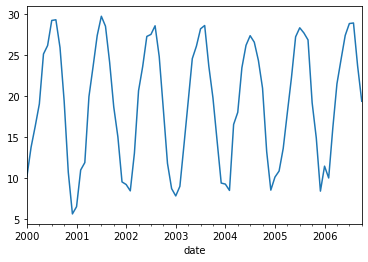

In [16]:
#how does average temperature change over the years after splitting
train.avg_temp.plot()

## Blow off the time series

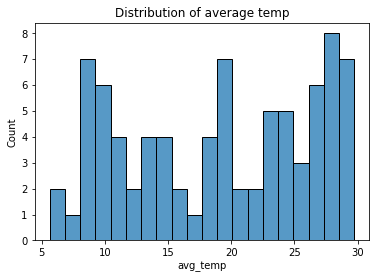

In [17]:
# Let's see the distribution of average temp
sns.histplot(train.avg_temp, bins = 20)
plt.title('Distribution of average temp');

In [18]:
# highest distribution of average temp are above 25

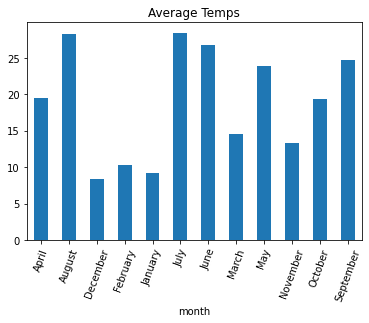

In [19]:
# Let's see average temp for each month
ax = train.groupby(train.month).mean().avg_temp.plot.bar()
ax.tick_params('x', rotation = 70)
plt.title('Average Temps');

In [20]:
#summer time months seems to be with the highest temperatures

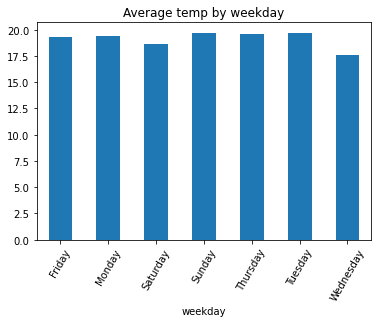

In [21]:
# Let's see the average temps by weekday
ax = train.groupby(train.weekday).mean().avg_temp.plot.bar()
ax.tick_params('x', rotation = 60)
plt.title('Average temp by weekday');

In [22]:
#the week days seems to have on average same temps

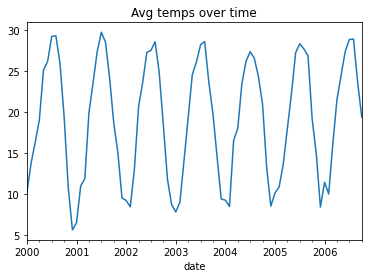

In [23]:
# Let's see the average temp over time
train.groupby(train.index).avg_temp.mean().plot()
plt.title('Avg temps over time');

In [24]:
#There is an upward trend in average temps over time

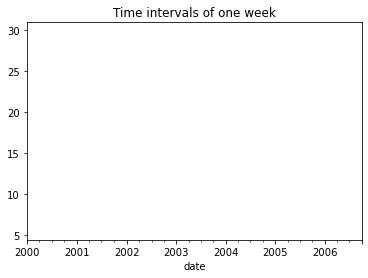

In [25]:
# Let's look at time intervals of one week
train.resample('1W').avg_temp.mean().plot()
plt.title('Time intervals of one week');

In [26]:
# no data to report in a week

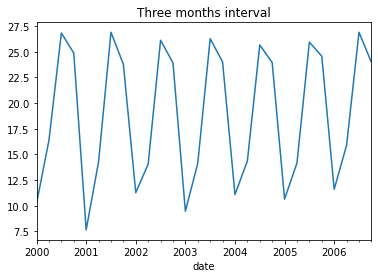

In [27]:
# Now let's take a look at 3 month intervals
train.resample('3M').avg_temp.mean().plot()
plt.title('Three months interval');

In [28]:
# we can now see clearly distinctions in average temps between summer (mid year)and winter (end year) times

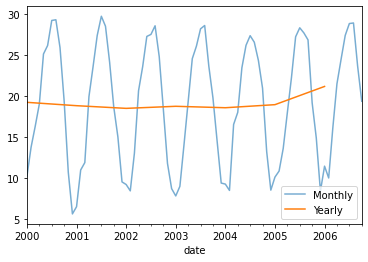

In [29]:
# can now visualize various intervals in one chart.

#train.resample('W').avg_temp.mean().plot(alpha = 0.4, label = 'Weekly')
train.resample('M').avg_temp.mean().plot(alpha = 0.6, label = 'Monthly')
train.resample('Y').avg_temp.mean().plot(label = 'Yearly')
plt.legend();

In [30]:
#we did not include weekly because it has no data
# there's consitency of average temperatures for both months and years over time

## Change in y over time

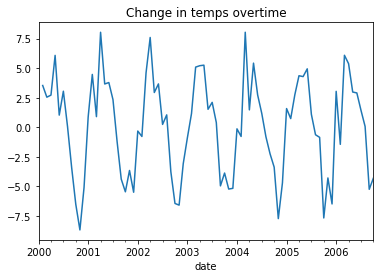

In [31]:
# plotting the change in average temps over time
train.groupby(train.index).avg_temp.mean().diff().plot()
plt.title("Change in temps overtime");

In [32]:
#there is consitency of temperatures over time but start falling from years 2005 and 2006

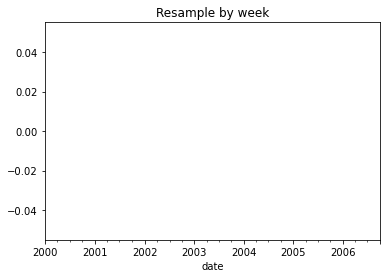

In [33]:
# plot resample by week
train.resample('W').avg_temp.mean().diff().plot()
plt.title('Resample by week');

In [34]:
#no data to report in a week

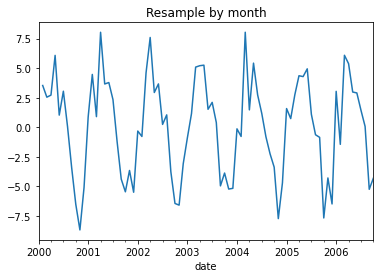

In [35]:
# plot resample by month
train.resample('M').avg_temp.mean().diff().plot()
plt.title('Resample by month');

In [36]:
#there is consitency of temperatures over time but start falling from years 2005 and 2006

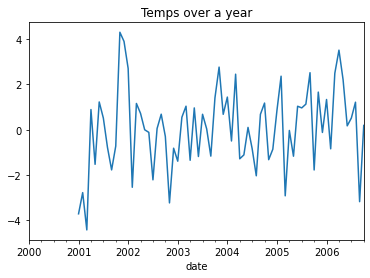

In [37]:
# plot temps over 1 year
train.resample('M').avg_temp.mean().diff(12).plot()
plt.title('Temps over a year');


In [38]:
# can see that temps increase and drop over time in each month

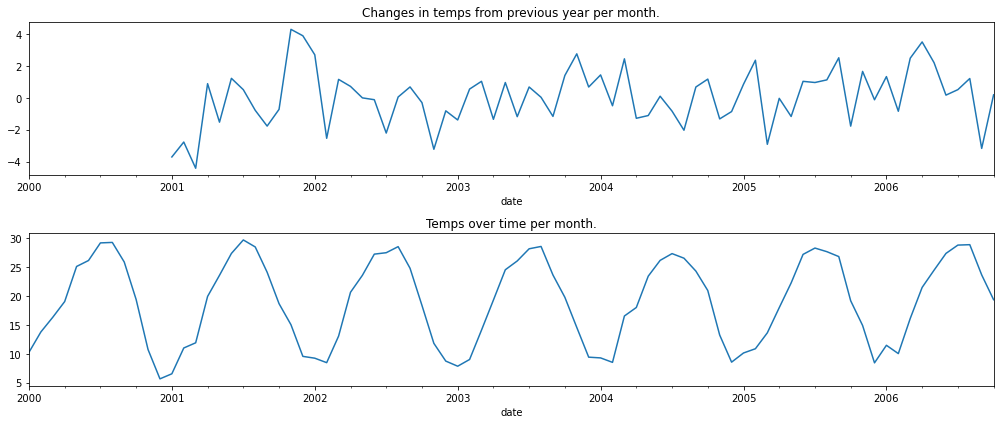

In [39]:
# plot previous chart next to the monthly temps chart.
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 6))

train.resample('M').avg_temp.mean().diff(12).plot(ax = ax[0])
ax[0].set_title('Changes in temps from previous year per month.')

train.resample('M').avg_temp.mean().plot(ax = ax[1])
ax[1].set_title('Temps over time per month.')

plt.tight_layout();

In [ ]:
#there's high temps during summer (mid) months over years

## Lag Plot

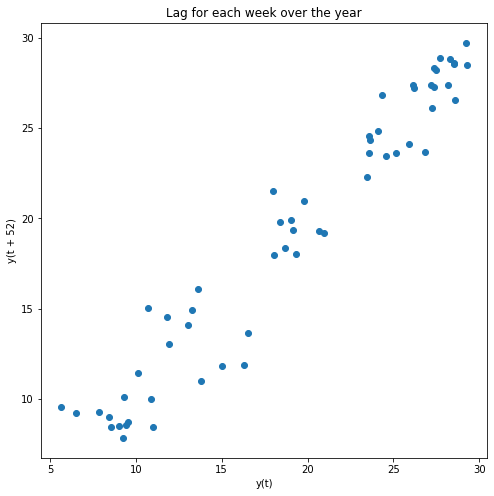

In [40]:
# plot lag for each week over one year
plt.figure(figsize = (8, 8))
pd.plotting.lag_plot(train.resample('W').avg_temp.mean(), lag = 52)
plt.title('Lag for each week over the year');

In [41]:
# We can see that there is a strong correlation between temps from year to another

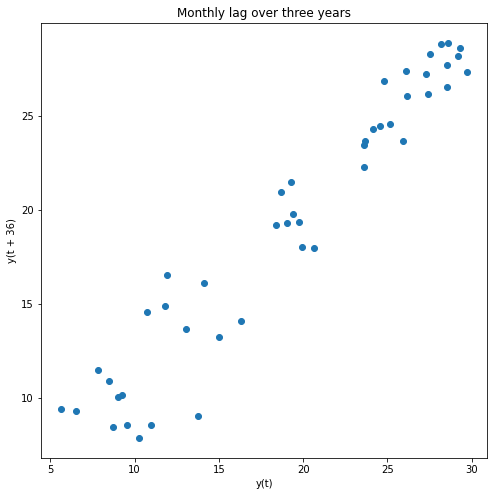

In [42]:
# plot monthly and 3 year lag
plt.figure(figsize = (8, 8))
pd.plotting.lag_plot(train.resample('M').avg_temp.mean(), lag = 36)
plt.title('Monthly lag over three years');

In [43]:
#the average temps seems to increase consistently over years

## Autocorrelation Plot

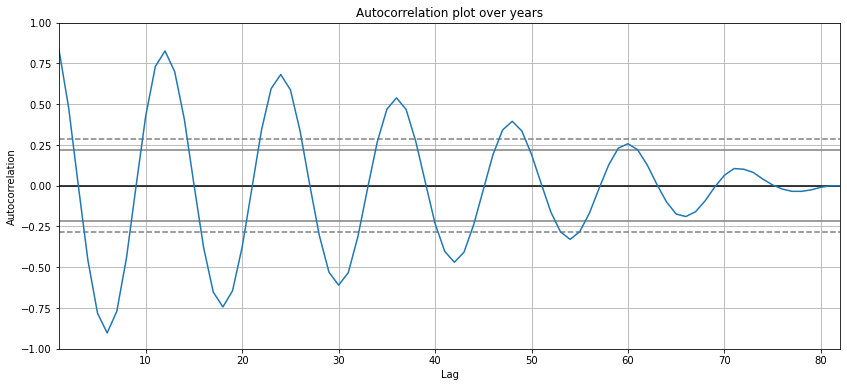

In [44]:
plt.figure(figsize = (14, 6))
pd.plotting.autocorrelation_plot(train.resample('M').avg_temp.mean())
plt.title('Autocorrelation plot over years');

In [45]:
#there is meaningful consistency and fluction in temps over years

## Seasonal Decomposition

In [46]:
y = train.avg_temp.resample('M').mean()

In [47]:
result = sm.tsa.seasonal_decompose(y)

In [48]:
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})

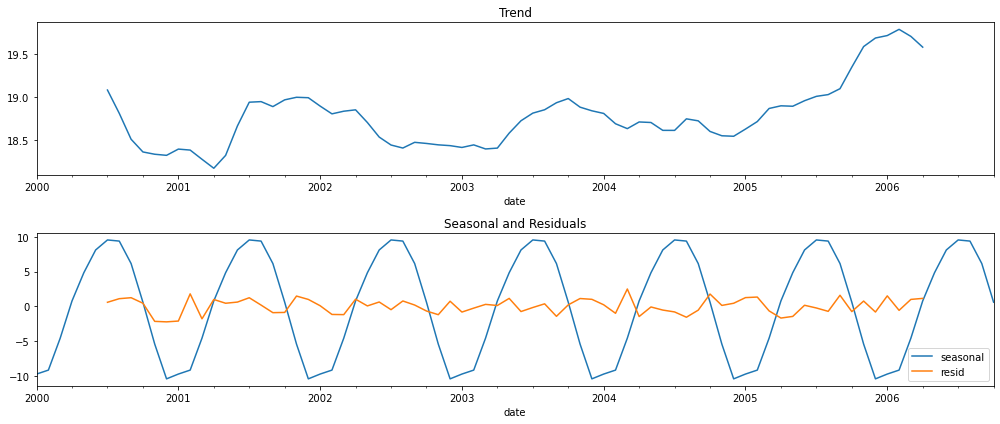

In [49]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 6))
decomposition.iloc[ : , 1].plot(ax = ax[0])
ax[0].set_title('Trend')

decomposition.iloc[ : , 2 : ].plot(ax = ax[1])
ax[1].set_title('Seasonal and Residuals')

plt.tight_layout();

In [ ]:
# still high temperatures mid (summer) months can be observed over time

### Exploration Takeaways: 

- Temperatures are much hotter in Summer months as expected for the Southern States 
- The Seasonal cycle is yearly
- Average temperatures can be observed as having a slight upward trend over time although consistent

## Modeling/Forecasting

In [50]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [51]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [52]:
    
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


In [53]:
def make_predictions():
    '''
    make a prediction column
    '''
    yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate.index)

    return yhat_df



In [54]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [55]:
# lets create an empty df that will store model type, avg_temp, and its rmse.
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


## 1. Last Observed Value

In [56]:
#lets check the last observed value
#The simplest method for forecasting is to predict all future values to be the last observed value.
temp=train['avg_temp'][-1:][0]
temp


19.368

In [57]:
#lets make predictions based on last observed value
yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate.index)

yhat_df.head()

,avg_temp
date,
2006-11-01,19.368
2006-12-01,19.368
2007-01-01,19.368
2007-02-01,19.368
2007-03-01,19.368


avg_temp -- RMSE: 7


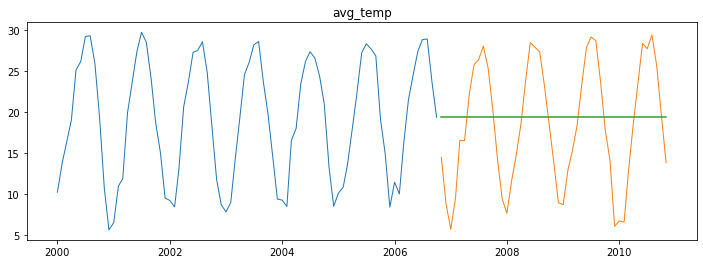

In [58]:
#plot to viz the last observed value with an RSME of 7
plot_and_eval('avg_temp')

In [59]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = "avg_temp")
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0


### With an RMSE of 7, Last Observed seems not be a good predictor

## 2. Simple Average

In [60]:
# now lets compute simple average of temperatures
temp = round(train['avg_temp'].mean(),2)
temp

19.1

In [61]:
#lets now make predictions with simple average
yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate.index)

yhat_df.head()

,avg_temp
date,
2006-11-01,19.1
2006-12-01,19.1
2007-01-01,19.1
2007-02-01,19.1
2007-03-01,19.1


avg_temp -- RMSE: 7


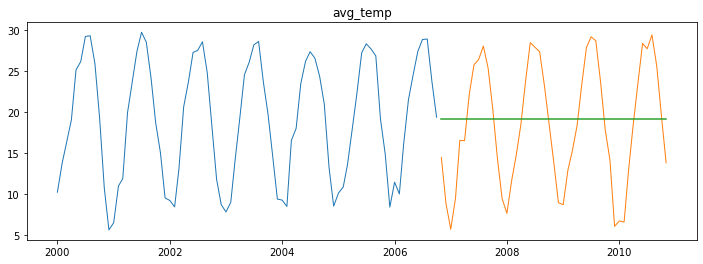

In [62]:
#lets visualize simple average predictions
plot_and_eval('avg_temp')

In [63]:
#let's append simple averages RMSE to evaluation dataframe
eval_df = append_eval_df(model_type='simple_average', 
                            target_var = 'avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,simple_average,avg_temp,7.0


### With an RMSE of 7, still Simple Average seems not be a good predictor

## 3. Moving average

In [64]:
#Let's look at rolling average over 3 months 
period = 3

temp = round(train['avg_temp'].rolling(period).mean()[-1],2)
print(temp)

23.98


In [65]:
#lets make another prediction with simple average
yhat_df = make_predictions()
yhat_df.head(5)

,avg_temp
date,
2006-11-01,23.98
2006-12-01,23.98
2007-01-01,23.98
2007-02-01,23.98
2007-03-01,23.98


avg_temp -- RMSE: 9


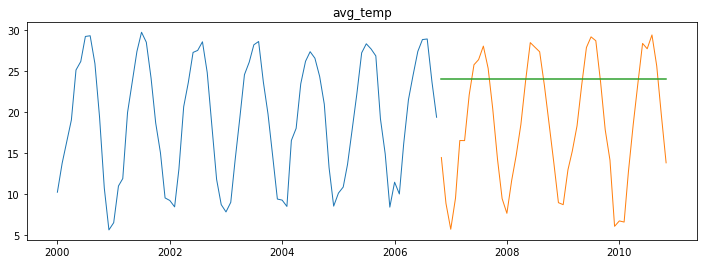

In [66]:
#lets visualize the rolling average over 3 months
plot_and_eval('avg_temp')

In [67]:
eval_df = append_eval_df(model_type = '3 month_moving_avg', 
                            target_var = 'avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,simple_average,avg_temp,7.0
2,3 month_moving_avg,avg_temp,9.0


In [69]:
#now let's test out 6 months, 1 year, 1 year and a half, 2 years, and 3 years for moving averages
periods = [6, 12, 18, 24, 36, 60]

for p in periods: 
    temp = round(train['avg_temp'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = "avg_temp")

In [70]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,simple_average,avg_temp,7.0
2,3 month_moving_avg,avg_temp,9.0
3,6month_moving_avg,avg_temp,10.0
4,6month_moving_avg,avg_temp,10.0
5,6month_moving_avg,avg_temp,10.0
6,6month_moving_avg,avg_temp,10.0
7,6month_moving_avg,avg_temp,10.0
8,12month_moving_avg,avg_temp,8.0
9,12month_moving_avg,avg_temp,8.0


In [71]:
# we can see there are temperature ties
min_temp_rmse = eval_df[eval_df.target_var=='avg_temp']['rmse'].min()

eval_df[eval_df.rmse==min_temp_rmse]

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,simple_average,avg_temp,7.0
18,24month_moving_avg,avg_temp,7.0
19,24month_moving_avg,avg_temp,7.0
20,24month_moving_avg,avg_temp,7.0
21,24month_moving_avg,avg_temp,7.0
22,24month_moving_avg,avg_temp,7.0
23,36month_moving_avg,avg_temp,7.0
24,36month_moving_avg,avg_temp,7.0
25,36month_moving_avg,avg_temp,7.0


### With an RMSE of 7, 3 Moving Avg seems not be a good predictor

## 4. Holt's Linear Trend

In [72]:
#Exponential smoothing applied to both the average and the trend (slope).
model = Holt(train["avg_temp"], exponential = False)
model = model.fit(smoothing_level = .1,
                    smoothing_slope = .1,
                    optimized = False)
yhat_items = model.predict(start = validate.index[0],
                            end = validate.index[-1])
yhat_df["avg_temp"] = round(yhat_items, 2)

In [73]:
#this model doesn't seem to be good 
yhat_df

,avg_temp
date,
2006-11-01,22.33
2006-12-01,22.62
2007-01-01,22.91
2007-02-01,23.19
2007-03-01,23.48
2007-04-01,23.77
2007-05-01,24.06
2007-06-01,24.35
2007-07-01,24.63


avg_temp -- RMSE: 13


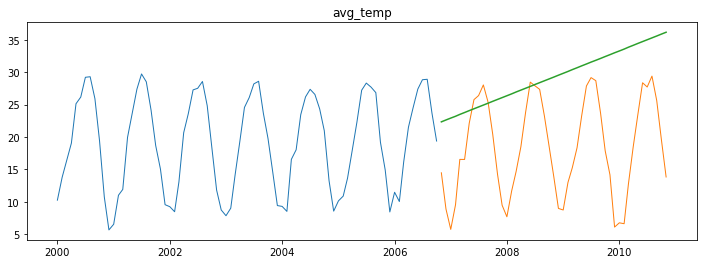

In [74]:
#now let's visual proof
plot_and_eval('avg_temp')

In [75]:
#we can add the Holt model anyway
eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = 'avg_temp')
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
19,24month_moving_avg,avg_temp,7.0
20,24month_moving_avg,avg_temp,7.0
21,24month_moving_avg,avg_temp,7.0
22,24month_moving_avg,avg_temp,7.0
23,36month_moving_avg,avg_temp,7.0
24,36month_moving_avg,avg_temp,7.0
18,24month_moving_avg,avg_temp,7.0
25,36month_moving_avg,avg_temp,7.0
27,36month_moving_avg,avg_temp,7.0


In [76]:
#lets check 6 way tie
eval_df[eval_df.rmse==min_temp_rmse]

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,simple_average,avg_temp,7.0
18,24month_moving_avg,avg_temp,7.0
19,24month_moving_avg,avg_temp,7.0
20,24month_moving_avg,avg_temp,7.0
21,24month_moving_avg,avg_temp,7.0
22,24month_moving_avg,avg_temp,7.0
23,36month_moving_avg,avg_temp,7.0
24,36month_moving_avg,avg_temp,7.0
25,36month_moving_avg,avg_temp,7.0


### With an RMSE of 13, Holt's Linear Trend is worse and not a good predictor

## 5. Based on Previous Cycle

In [77]:
#checking df index to see the years
df.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01'],
              dtype='datetime64[ns]', name='date', length=165, freq=None)

## Re - split data

In [78]:
train = df[:'2011']
validate = df['2012']
test = df['2013']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(144, 5)
(12, 5)
(9, 5)


,avg_temp,avg_temp_unc,year,month,weekday
date,,,,,
2011-08-01,31.401,0.182,2011,August,Monday
2011-09-01,25.696,0.189,2011,September,Thursday
2011-10-01,19.514,0.166,2011,October,Saturday
2011-11-01,13.975,0.177,2011,November,Tuesday
2011-12-01,7.774,0.253,2011,December,Thursday


## Make predictions

In [79]:
#lets do prediction with a year added to train (2011)
yhat_df = pd.DataFrame(train['2011'].avg_temp + train.avg_temp.diff(12).mean())

- Back to Predictions

In [80]:
train.loc['2011'].head()

,avg_temp,avg_temp_unc,year,month,weekday
date,,,,,
2011-01-01,7.121,0.198,2011,January,Saturday
2011-02-01,9.245,0.103,2011,February,Tuesday
2011-03-01,16.565,0.156,2011,March,Tuesday
2011-04-01,21.351,0.149,2011,April,Friday
2011-05-01,23.529,0.192,2011,May,Sunday


In [81]:
yhat_df.head()

,avg_temp
date,
2011-01-01,7.164644
2011-02-01,9.288644
2011-03-01,16.608644
2011-04-01,21.394644
2011-05-01,23.572644


In [82]:
#lets predict vs actual value
pd.concat([yhat_df.head(1), validate.head(1)])

,avg_temp,avg_temp_unc,year,month,weekday
date,,,,,
2011-01-01,7.164644,NaN,NaN,NaN,NaN
2012-01-01,10.127000,0.238,2012.0,January,Sunday


In [83]:
# set yhat_df to index of validate
yhat_df.index = validate.index

In [84]:
yhat_df.describe()

,avg_temp
count,12.000000
mean,19.761727
std,8.865858
min,7.164644
25%,12.836144
50%,20.476144
75%,26.744394
max,31.444644


In [85]:
yhat_df.head()

,avg_temp
date,
2012-01-01,7.164644
2012-02-01,9.288644
2012-03-01,16.608644
2012-04-01,21.394644
2012-05-01,23.572644


In [86]:
yhat_df.shape

(12, 1)

## Plot and evaluate

avg_temp -- RMSE: 2


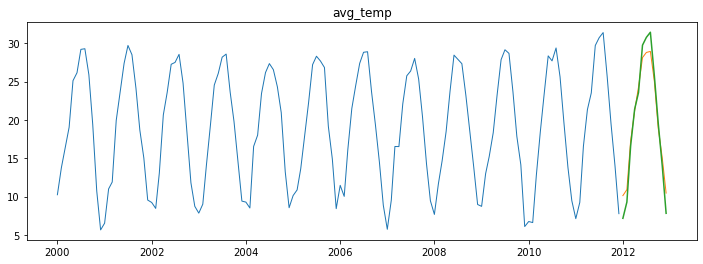

In [87]:
plot_and_eval(target_var = 'avg_temp')
eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = 'avg_temp')

### Based on Previous Cycle after evaluation, it has an RMSE of 2 which is the best over all models

## Conclusion

### Which model did the best

In [88]:
min_rmse = eval_df['rmse'].min()

In [89]:
# find which model that has the best RMSE
eval_df[(eval_df.rmse == min_rmse)]

,model_type,target_var,rmse
34,previous_year,avg_temp,2.0


In [ ]:
#Base on Previous Cycle/Year has the best RMSE of 2.0

In [90]:
#Let's test it out on our out-of-sample data

#We will be using train + validate to predict test.

In [91]:
#let's predict 2013
yhat_df = validate.avg_temp + train.avg_temp.diff(12).mean()
yhat_df = pd.DataFrame(yhat_df.head(9))
yhat_df.index = test.index

In [92]:
#the rmse of the average temperature for our test, please.
rmse_temp = sqrt(mean_squared_error(test['avg_temp'], 
                                       yhat_df['avg_temp']))

In [93]:
print('rmse-temp: ', rmse_temp)

rmse-temp:  1.9941925390170856


In [ ]:
# as can be seen above, it is in consistent with Previous year RMSE of 2.0

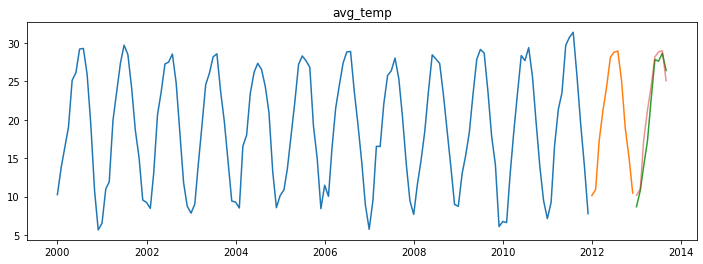

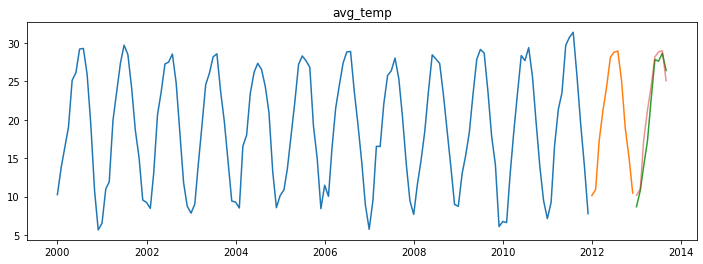

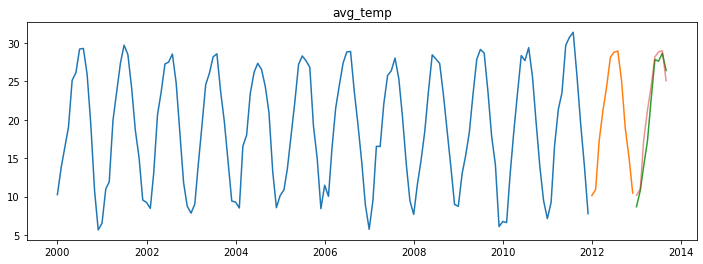

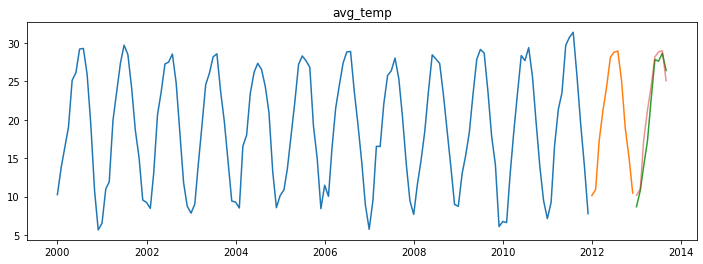

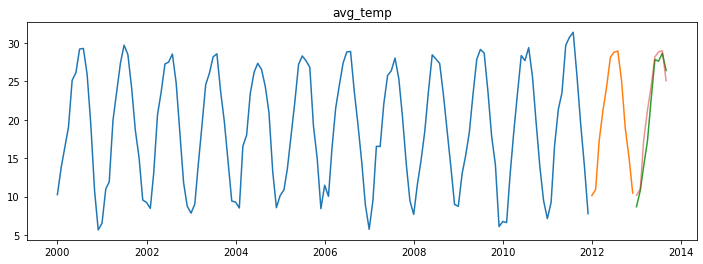

In [94]:
# plot on train columns to see final avg temps
for col in train.columns:
    final_plot("avg_temp")

In [95]:
#2013 prediction
yhat_df = test.avg_temp + train.avg_temp.diff(12).mean()
yhat_df = pd.DataFrame(yhat_df.head(9))
yhat_df.index = test.index + pd.Timedelta('1Y')

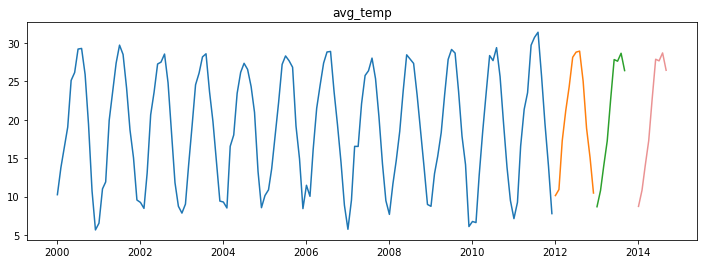

In [96]:
#final plot on test column with prediction of 2013
final_plot("avg_temp")

## Therefore:
-The previous year's cycle model worked out better than the rest of the models because it had the lowest RMSE score

-The previous year's cycle for test had an RMSE of 2.0
